**Leukemia Classification** Using Convaluted Neural 


In [35]:
# imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from numpy import savetxt

from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import load_img, img_to_array, smart_resize
# For reproducibility
np.random.seed(42)
from numpy.random import seed
seed(42)

In [16]:
# Mounting G-Drive FOLDER
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Checking data folder
!ls drive/MyDrive/datasets/C-NMC_Leukemia/training_data/fold_0

all  hem


In [ ]:
# Creating train_ds and val_ds for model
# This will go through the folder and find photos and classify them based on folder location
# ie. if in all folder will label all (1)
train_ds = image_dataset_from_directory(
    'drive/MyDrive/datasets/C-NMC_Leukemia/training_data/fold_0/', # Directory
    image_size = (256, 256), # make sure all images are the same size
    batch_size = 32, # This will load 32 images at a time, memory can't hold them all
    seed = 42, # random seed for reproducibility
    validation_split = 0.2, 
    subset = 'training',
    label_mode = 'binary'
)

val_ds = image_dataset_from_directory(
    'drive/MyDrive/datasets/C-NMC_Leukemia/training_data/fold_0/',
    image_size = (256, 256),
    batch_size = 32,
    seed = 42,
    validation_split = 0.2,
    subset = 'validation',
    label_mode = 'binary'
)

Found 3527 files belonging to 2 classes.
Using 2822 files for training.
Found 3527 files belonging to 2 classes.
Using 705 files for validation.


In [ ]:
# Calculating null model
print(f'ALL is {round(2397/3527,2)}%')
print(f'HEM is {round(1130/3527, 2)}%')

ALL is 0.68%
HEM is 0.32%


Our null model shows that if we were to guess ALL for every cell we would be right 68% of the time.

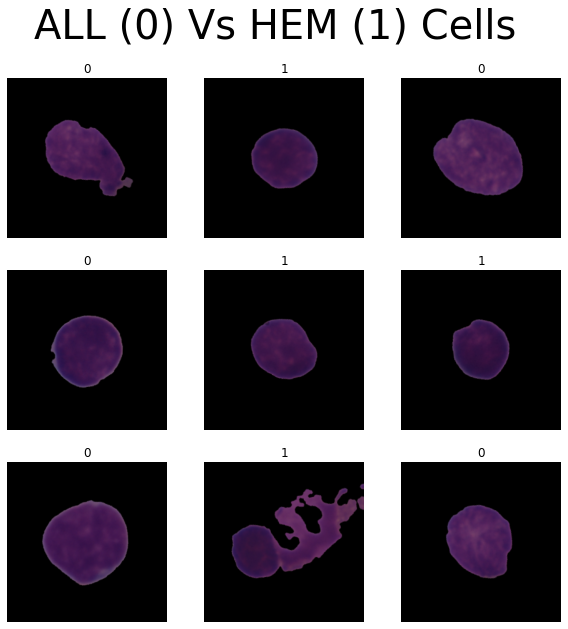

In [60]:
# Performing EDA on classes
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")
plt.suptitle('ALL (0) Vs HEM (1) Cells', fontsize = 40) 
#plt.savefig('/content/drive/MyDrive/ga_project_4/all_vs_hem_cells')

Aside from the image in position 3, 2 it is difficult to distinguish between hem and all cells. Hopefully the model can distinguish all cells better than the human eye.

# Modeling images without data augmentation

In [ ]:
# Base Model
model_b = Sequential()

model_b.add(layers.Input(shape = (256,256,3)))

# The 1. below garuntees we get a float for the normalization
model_b.add(layers.Rescaling(1./255))


# First convolution
model_b.add(Conv2D(64, # Number of filters
                 (3,3), # Kernal size, generally 3 by 3
                 activation = 'relu'))

# Passing into the max pooling layer
model_b.add(MaxPooling2D(pool_size = (2,2), # Default pool size
                       ))
# Second Convolution
model_b.add(Conv2D(64, (3,3), activation='relu'))
model_b.add(MaxPooling2D(pool_size=(2,2)))

# Flatten
model_b.add(Flatten())

# Fully Connected
model_b.add(Dense(64, activation='relu'))
model_b.add(Dense(1, activation='sigmoid'))

#Compile
model_b.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# Fitting the model
h_b = model_b.fit(train_ds, validation_data= val_ds, epochs = 5)

Epoch 1/5
89/89 [==============================] - 355s 4s/step - loss: 0.4693 - accuracy: 0.7987 - val_loss: 0.4385 - val_accuracy: 0.8085
Epoch 2/5
89/89 [==============================] - 15s 155ms/step - loss: 0.4076 - accuracy: 0.8320 - val_loss: 0.4545 - val_accuracy: 0.8071
Epoch 3/5
89/89 [==============================] - 14s 149ms/step - loss: 0.3674 - accuracy: 0.8451 - val_loss: 0.4382 - val_accuracy: 0.8170
Epoch 4/5
89/89 [==============================] - 14s 144ms/step - loss: 0.3082 - accuracy: 0.8703 - val_loss: 0.4716 - val_accuracy: 0.8028
Epoch 5/5
89/89 [==============================] - 14s 147ms/step - loss: 0.2570 - accuracy: 0.8937 - val_loss: 0.5432 - val_accuracy: 0.8000


In [ ]:
 # Scoring model
print(h_b.history['loss'][-1], h_b.history['val_loss'][-1])
print(h_b.history['accuracy'][-1], h_b.history['val_accuracy'][-1])

0.2570217549800873 0.5432436466217041
0.8936924338340759 0.800000011920929


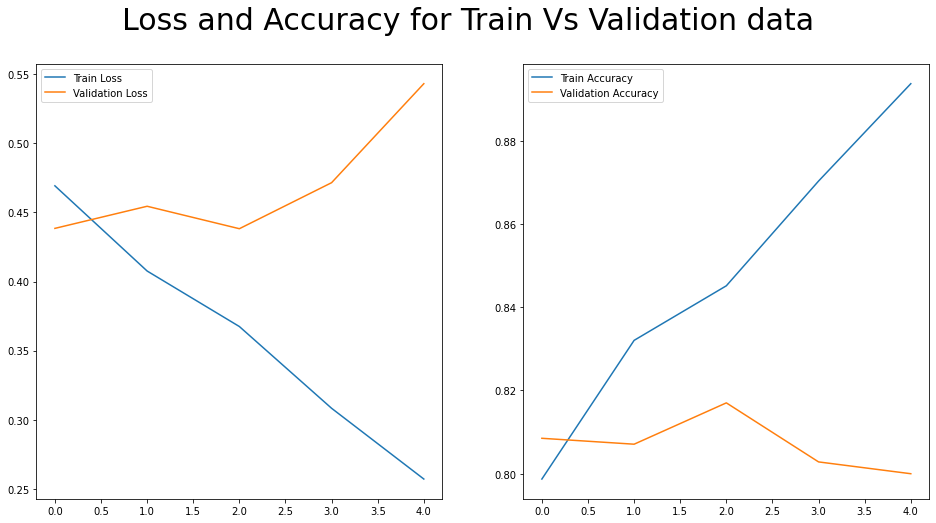

In [ ]:
# Plotting loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8),)
fig.suptitle('Loss and Accuracy for Train Vs Validation data', fontsize =30)
figsize=(16,16),
ax1.plot(h_b.history['loss'], label = 'Train Loss'),
ax1.plot(h_b.history['val_loss'], label = 'Validation Loss'),
ax1.legend()
ax2.plot(h_b.history['accuracy'], label = 'Train Accuracy'),
ax2.plot(h_b.history['val_accuracy'], label = 'Validation Accuracy')
ax2.legend();
plt.savefig('/content/drive/MyDrive/ga_project_4/no_augmentation_plot')

The model is a bit overfit after only 5 epochs, runninhg more would surely caus eit to become more overfit. There may be a way to inprove the model and reduce the variance at the same time.


Data augmentation artificially introduces diversity by applying random yet realistic transformations to the training images, such as random horizontal flipping or small random rotations. This can be helpful for both small datasets and preventing overfitting of a model. 

In [ ]:
# Instantiating data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


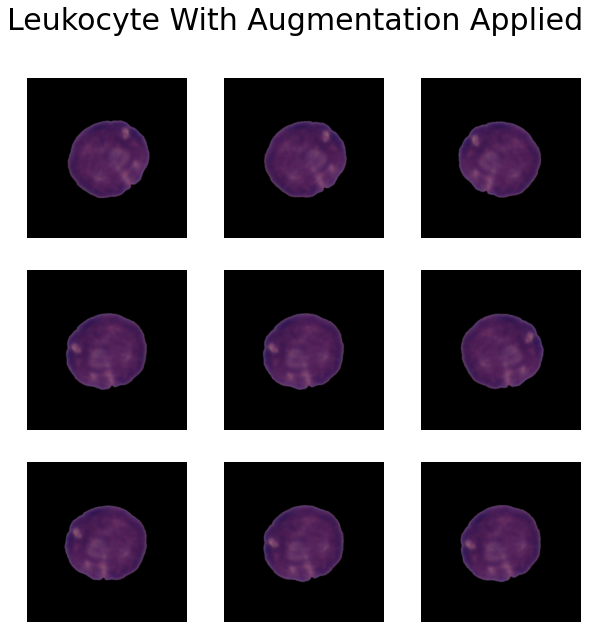

In [ ]:
# Plotting one image with data augmentation applied
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

plt.suptitle('Leukocyte With Augmentation Applied', fontsize = 30) 
#plt.savefig('/content/drive/MyDrive/ga_project_4/image_augmentation')

In general, data augmentation performed on less uniform images is far more stark in differences between images. However, due spherical shape of cells, it is difficult for the human eye to tell a difinitive difference between the above images. It will be interesting to see if the model performs better with augmentation.

In [ ]:
# Apply `data_augmentation` to the training images. Code adapted from https://keras.io/examples/vision/image_classification_from_scratch/
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization. 
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
# Base Model
model_1 = Sequential()

model_1.add(layers.Input(shape = (256,256,3)))

# The 1. below garuntees we get a float for the normalization
model_1.add(layers.Rescaling(1./255))


# First convolution
model_1.add(Conv2D(64, # Number of filters
                 (3,3), # Kernal size, generally 3 by 3
                 activation = 'relu'))

# Passing into the max pooling layer
model_1.add(MaxPooling2D(pool_size = (2,2), # Default pool size
                       ))
# Second Convolution
model_1.add(Conv2D(64, (3,3), activation='relu'))
model_1.add(MaxPooling2D(pool_size=(2,2)))

# Flatten
model_1.add(Flatten())

# Fully Connected
model_1.add(Dense(64, activation='relu'))
model_1.add(Dense(1, activation='sigmoid'))

#Compile
model_1.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [22]:
# Fitting augmented model with 5 epochs
h_1 = model_1.fit(train_ds, validation_data= val_ds, epochs = 5)

Epoch 1/5
89/89 [==============================] - 34s 368ms/step - loss: 0.3508 - accuracy: 0.8540 - val_loss: 0.3371 - val_accuracy: 0.8667
Epoch 2/5
89/89 [==============================] - 29s 319ms/step - loss: 0.3529 - accuracy: 0.8565 - val_loss: 0.3534 - val_accuracy: 0.8496
Epoch 3/5
89/89 [==============================] - 30s 328ms/step - loss: 0.3232 - accuracy: 0.8661 - val_loss: 0.3051 - val_accuracy: 0.8738
Epoch 4/5
89/89 [==============================] - 36s 377ms/step - loss: 0.3327 - accuracy: 0.8682 - val_loss: 0.4562 - val_accuracy: 0.8255
Epoch 5/5
89/89 [==============================] - 30s 325ms/step - loss: 0.3296 - accuracy: 0.8636 - val_loss: 0.3319 - val_accuracy: 0.8638


In [23]:
# Scoring model
print(h_1.history['loss'][-1], h_1.history['val_loss'][-1])
print(h_1.history['accuracy'][-1], h_1.history['val_accuracy'][-1])

0.3295656740665436 0.33190470933914185
0.8635719418525696 0.8638297915458679


The model is mnuch less overfit due to the augmentation. 

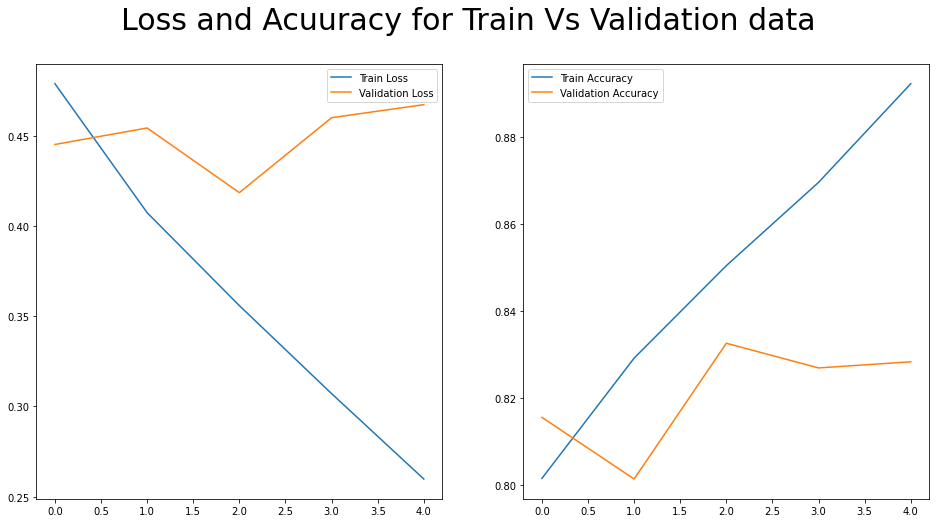

In [ ]:
# Plotting loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8),)
fig.suptitle('Loss and Acuuracy for Train Vs Validation data', fontsize =30)
figsize=(16,16),
ax1.plot(h_1.history['loss'], label = 'Train Loss'),
ax1.plot(h_1.history['val_loss'], label = 'Validation Loss'),
ax1.legend()
ax2.plot(h_1.history['accuracy'], label = 'Train Accuracy'),
ax2.plot(h_1.history['val_accuracy'], label = 'Validation Accuracy')
ax2.legend();
plt.savefig('/content/drive/MyDrive/ga_project_4/with_image_augmentation')

No tryinhg the same model with more epochs.

In [24]:
# Fitting augmented model with 10 epochs
h_1 = model_1.fit(train_ds, validation_data= val_ds, epochs = 10)

Epoch 1/10
89/89 [==============================] - 27s 289ms/step - loss: 0.3106 - accuracy: 0.8753 - val_loss: 0.3324 - val_accuracy: 0.8667
Epoch 2/10
89/89 [==============================] - 27s 299ms/step - loss: 0.3045 - accuracy: 0.8728 - val_loss: 0.2841 - val_accuracy: 0.8766
Epoch 3/10
89/89 [==============================] - 28s 301ms/step - loss: 0.2972 - accuracy: 0.8781 - val_loss: 0.2809 - val_accuracy: 0.8851
Epoch 4/10
89/89 [==============================] - 32s 355ms/step - loss: 0.3010 - accuracy: 0.8763 - val_loss: 0.3165 - val_accuracy: 0.8738
Epoch 5/10
89/89 [==============================] - 28s 304ms/step - loss: 0.2800 - accuracy: 0.8824 - val_loss: 0.3553 - val_accuracy: 0.8695
Epoch 6/10
89/89 [==============================] - 31s 329ms/step - loss: 0.2730 - accuracy: 0.8887 - val_loss: 0.4259 - val_accuracy: 0.8553
Epoch 7/10
89/89 [==============================] - 27s 298ms/step - loss: 0.2743 - accuracy: 0.8933 - val_loss: 0.2667 - val_accuracy: 0.8936

In [25]:
# Scoring model
print(h_1.history['loss'][-1], h_1.history['val_loss'][-1])
print(h_1.history['accuracy'][-1], h_1.history['val_accuracy'][-1])

0.2817630171775818 0.2702823281288147
0.8897944688796997 0.8865247964859009


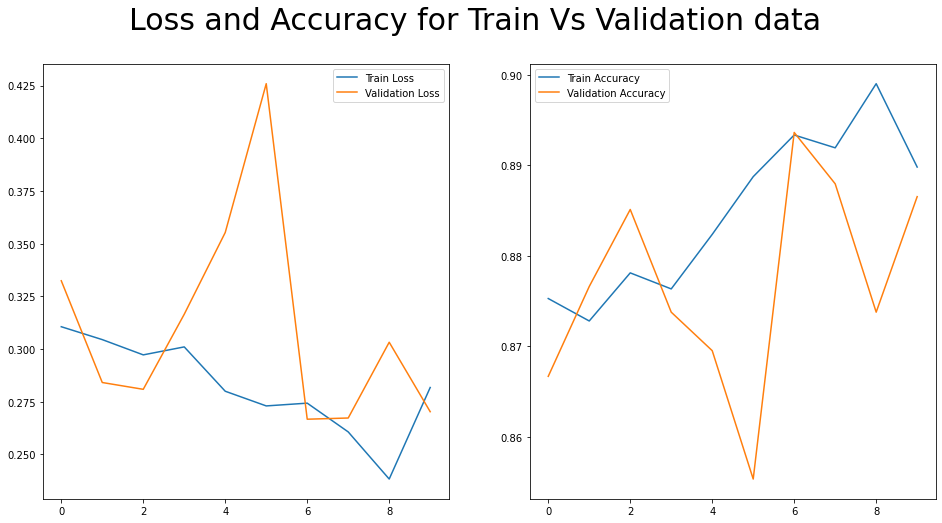

In [33]:
# Plotting loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8),)
fig.suptitle('Loss and Accuracy for Train Vs Validation data', fontsize = 30)
figsize=(16,16),
ax1.plot(h_1.history['loss'], label = 'Train Loss'),
ax1.plot(h_1.history['val_loss'], label = 'Validation Loss'),
ax1.legend()
ax2.plot(h_1.history['accuracy'], label = 'Train Accuracy'),
ax2.plot(h_1.history['val_accuracy'], label = 'Validation Accuracy')
ax2.legend();
#plt.savefig('/content/drive/MyDrive/ga_project_4/base_model_10_epochs')

# **Loading Transfer Learning Model**

In [ ]:
# Inlcude top = false means it will not take the input layer, weights taken from the imagenet dataset, it has many classes
# and we just want a single output for this binary problem.
effnet = EfficientNetB0(include_top = False, weights = 'imagenet')

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
# This will prevent the model from bein trained by our data as we want it to maintain the weights
effnet.trainable = False
effnet.trainable

False

In [ ]:
# Transfer learning EfficientNetB0 model
model_2 = Sequential()
model_2.add(effnet)
model_2.add(GlobalAveragePooling2D())# Required, not 100% sure why but may be becasue of teh shape going into teh final layer, all it does is get teh shape right
# Flatten
model_2.add(Flatten())

# Fully Connected
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(1, activation='sigmoid'))

#Compile
model_2.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# Fitting the model
h_2 = model_2.fit(train_ds, validation_data= val_ds, epochs = 10)

Epoch 1/10
89/89 [==============================] - 38s 333ms/step - loss: 0.4860 - accuracy: 0.7764 - val_loss: 0.4245 - val_accuracy: 0.8170
Epoch 2/10
89/89 [==============================] - 29s 312ms/step - loss: 0.4325 - accuracy: 0.8157 - val_loss: 0.4331 - val_accuracy: 0.8227
Epoch 3/10
89/89 [==============================] - 31s 336ms/step - loss: 0.4095 - accuracy: 0.8271 - val_loss: 0.3886 - val_accuracy: 0.8454
Epoch 4/10
89/89 [==============================] - 29s 319ms/step - loss: 0.3843 - accuracy: 0.8423 - val_loss: 0.3903 - val_accuracy: 0.8496
Epoch 5/10
89/89 [==============================] - 29s 313ms/step - loss: 0.3903 - accuracy: 0.8349 - val_loss: 0.3886 - val_accuracy: 0.8496
Epoch 6/10
89/89 [==============================] - 29s 311ms/step - loss: 0.3770 - accuracy: 0.8437 - val_loss: 0.3847 - val_accuracy: 0.8525
Epoch 7/10
89/89 [==============================] - 29s 315ms/step - loss: 0.3644 - accuracy: 0.8476 - val_loss: 0.3625 - val_accuracy: 0.8596

In [ ]:
# Scoring model
print(h_2.history['loss'][-1], h_2.history['val_loss'][-1])
print(h_2.history['accuracy'][-1], h_2.history['val_accuracy'][-1])

0.34469786286354065 0.46091750264167786
0.8586109280586243 0.8269503712654114


In [26]:
# Previous base model with  10 epochs score
print(h_1.history['loss'][-1], h_1.history['val_loss'][-1])
print(h_1.history['accuracy'][-1], h_1.history['val_accuracy'][-1])

0.2817630171775818 0.2702823281288147
0.8897944688796997 0.8865247964859009


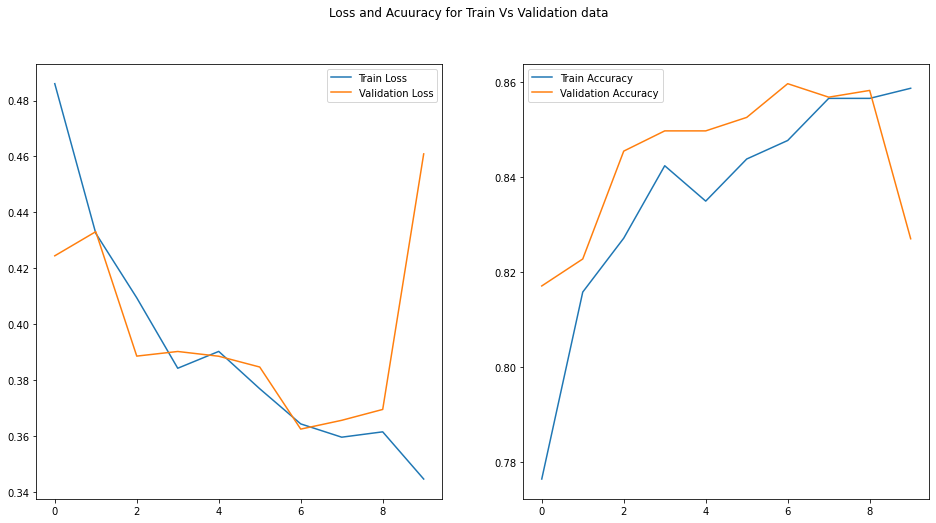

In [ ]:
# Plotting loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8),)
fig.suptitle('Loss and Acuuracy for Train Vs Validation data')
figsize=(16,16),
ax1.plot(h_2.history['loss'], label = 'Train Loss'),
ax1.plot(h_2.history['val_loss'], label = 'Validation Loss'),
ax1.legend()
ax2.plot(h_2.history['accuracy'], label = 'Train Accuracy'),
ax2.plot(h_2.history['val_accuracy'], label = 'Validation Accuracy')
ax2.legend();

This did not score as well as teh base model so moving on with the base model on a larger dataset.

# Running model on larger image training/validation set

The Kaggle dataset consists of 3 folders with between 2,000 and 3,000 images each. Here the folders have been combined to run the CNN model on all of the images to see if that improves performance.

In [ ]:
# Checking data folder
!ls drive/MyDrive/datasets/C-NMC_Leukemia/training_data/combined

all  hem


In [ ]:
# Creating train_ds and val_ds for model
# This will go through the folder and find photos and classify them based on folder location
# ie. if in all folder will label all (1)
train_ds = image_dataset_from_directory(
    'drive/MyDrive/datasets/C-NMC_Leukemia/training_data/combined/', # Directory
    image_size = (256, 256), # make sure all images are the same size
    batch_size = 32, # This will load 32 images at a time, memory can't hold them all
    seed = 42, # random seed for reproducibility
    validation_split = 0.2, 
    subset = 'training',
    label_mode = 'binary'
)

val_ds = image_dataset_from_directory(
    'drive/MyDrive/datasets/C-NMC_Leukemia/training_data/combined/',
    image_size = (256, 256),
    batch_size = 32,
    seed = 42,
    validation_split = 0.2,
    subset = 'validation',
    label_mode = 'binary'
)

Found 10661 files belonging to 2 classes.
Using 8529 files for training.
Found 10661 files belonging to 2 classes.
Using 2132 files for validation.


In [ ]:
# Instantiating data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
# Base Model on larger data set
model = Sequential()

model.add(layers.Input(shape = (256,256,3)))

# The 1. below garuntees we get a float for the normalization
model.add(layers.Rescaling(1./255))


# First convolution
model.add(Conv2D(64, # Number of filters
                 (3,3), # Kernal size, generally 3 by 3
                 activation = 'relu'))

# Passing into the max pooling layer
model.add(MaxPooling2D(pool_size = (2,2), # Default pool size
                       ))
# Second Convolution
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Flatten
model.add(Flatten())

# Fully Connected
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

#Compile
model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# Fitting the model
h = model.fit(train_ds, validation_data= val_ds, epochs = 5)

Epoch 1/5
267/267 [==============================] - 115s 370ms/step - loss: 0.4758 - accuracy: 0.7931 - val_loss: 0.4538 - val_accuracy: 0.7927
Epoch 2/5
267/267 [==============================] - 98s 363ms/step - loss: 0.4513 - accuracy: 0.8061 - val_loss: 0.5011 - val_accuracy: 0.7997
Epoch 3/5
267/267 [==============================] - 98s 360ms/step - loss: 0.4491 - accuracy: 0.8063 - val_loss: 0.4582 - val_accuracy: 0.7978
Epoch 4/5
267/267 [==============================] - 98s 359ms/step - loss: 0.4427 - accuracy: 0.8089 - val_loss: 0.4537 - val_accuracy: 0.7950
Epoch 5/5
267/267 [==============================] - 99s 364ms/step - loss: 0.4358 - accuracy: 0.8149 - val_loss: 0.4468 - val_accuracy: 0.8086


In [ ]:
# Scoring model
print(h.history['loss'][-1], h.history['val_loss'][-1])
print(h.history['accuracy'][-1], h.history['val_accuracy'][-1])

0.43578001856803894 0.44684475660324097
0.8148669004440308 0.8086304068565369


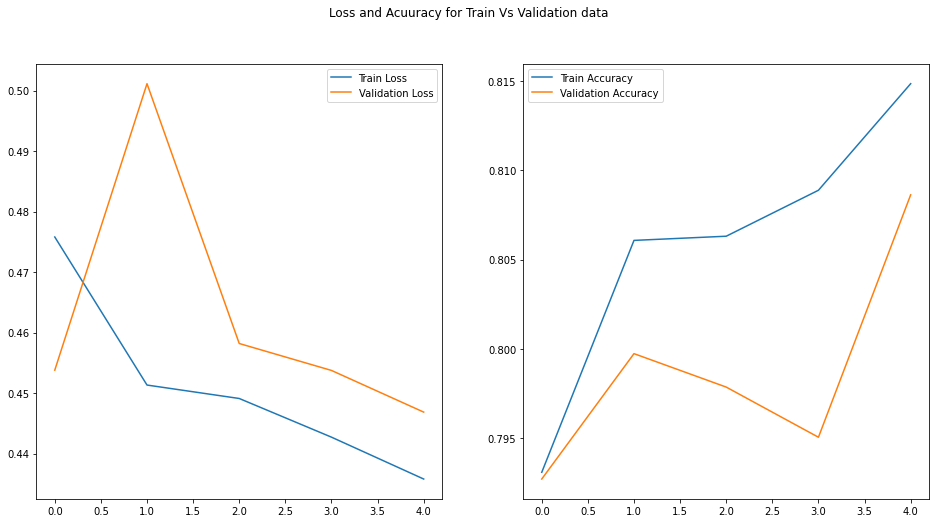

In [ ]:
# Plotting loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8),)
fig.suptitle('Loss and Acuuracy for Train Vs Validation data')
figsize=(16,16),
ax1.plot(h.history['loss'], label = 'Train Loss'),
ax1.plot(h.history['val_loss'], label = 'Validation Loss'),
ax1.legend()
ax2.plot(h.history['accuracy'], label = 'Train Accuracy'),
ax2.plot(h.history['val_accuracy'], label = 'Validation Accuracy')
ax2.legend();

In [ ]:
 # Fitting the model
 h = model.fit(train_ds, validation_data= val_ds, epochs = 10)

Epoch 1/10
267/267 [==============================] - 106s 357ms/step - loss: 0.4678 - accuracy: 0.7955 - val_loss: 0.4477 - val_accuracy: 0.8007
Epoch 2/10
267/267 [==============================] - 98s 359ms/step - loss: 0.4365 - accuracy: 0.8160 - val_loss: 0.4742 - val_accuracy: 0.8147
Epoch 3/10
267/267 [==============================] - 99s 364ms/step - loss: 0.4269 - accuracy: 0.8204 - val_loss: 0.4710 - val_accuracy: 0.8007
Epoch 4/10
267/267 [==============================] - 100s 367ms/step - loss: 0.4123 - accuracy: 0.8284 - val_loss: 0.4484 - val_accuracy: 0.8227
Epoch 5/10
267/267 [==============================] - 98s 363ms/step - loss: 0.3984 - accuracy: 0.8361 - val_loss: 0.3911 - val_accuracy: 0.8354
Epoch 6/10
267/267 [==============================] - 98s 363ms/step - loss: 0.3781 - accuracy: 0.8470 - val_loss: 0.4391 - val_accuracy: 0.8316
Epoch 7/10
267/267 [==============================] - 98s 363ms/step - loss: 0.3630 - accuracy: 0.8509 - val_loss: 0.3652 - val_

In [ ]:
# Scoring model
print(h.history['loss'][-1], h.history['val_loss'][-1])
print(h.history['accuracy'][-1], h.history['val_accuracy'][-1])

0.34378063678741455 0.3435012102127075
0.8618829846382141 0.8602251410484314


In [27]:
# Previous base model on single image folder with  10 epochs score
print(h_1.history['loss'][-1], h_1.history['val_loss'][-1])
print(h_1.history['accuracy'][-1], h_1.history['val_accuracy'][-1])

0.2817630171775818 0.2702823281288147
0.8897944688796997 0.8865247964859009


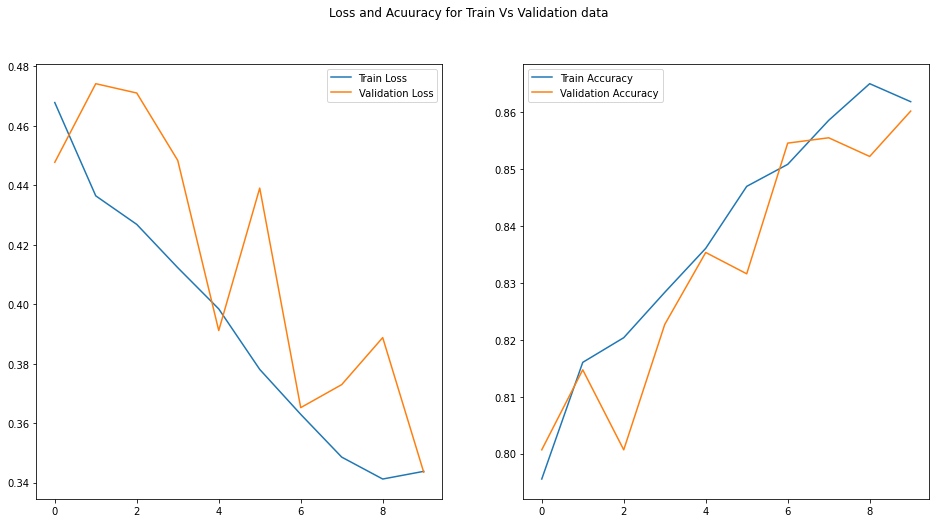

In [ ]:
# Plotting loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8),)
fig.suptitle('Loss and Acuuracy for Train Vs Validation data')
figsize=(16,16),
ax1.plot(h.history['loss'], label = 'Train Loss'),
ax1.plot(h.history['val_loss'], label = 'Validation Loss'),
ax1.legend()
ax2.plot(h.history['accuracy'], label = 'Train Accuracy'),
ax2.plot(h.history['val_accuracy'], label = 'Validation Accuracy')
ax2.legend();

Optimizing the model on the large dataset is unfortunately not ideal for this project. The previous 2 models took a full day to run as Colab kept crashing and getting stuck running the epochs as well as using up almost of of my available computing units for only 2 fits of the model.. In the intereset of time and money,  optimization of the model will be done with the original dataset consisting of only 1 of teh image folders.

# Optimizing Model

Using base model from before from one folder, not combined folders, and image augmentation for optimization. Trying original base model with more epochs.

In [ ]:
# Creating train_ds and val_ds for model- Going back to original single folder
# This will go through the folder and find photos and classify them based on folder location
# ie. if in all folder will label all (1)
train_ds = image_dataset_from_directory(
    'drive/MyDrive/datasets/C-NMC_Leukemia/training_data/fold_0/', # Directory
    image_size = (256, 256), # make sure all images are the same size
    batch_size = 32, # This will load 32 images at a time, memory can't hold them all
    seed = 42, # random seed for reproducibility
    validation_split = 0.2, 
    subset = 'training',
    label_mode = 'binary'
)

val_ds = image_dataset_from_directory(
    'drive/MyDrive/datasets/C-NMC_Leukemia/training_data/fold_0/',
    image_size = (256, 256),
    batch_size = 32,
    seed = 42,
    validation_split = 0.2,
    subset = 'validation',
    label_mode = 'binary'
)

Found 3527 files belonging to 2 classes.
Using 2822 files for training.
Found 3527 files belonging to 2 classes.
Using 705 files for validation.


In [ ]:
# Instantiating data augmentation
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)


In [ ]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
# Base Model 
model_3 = Sequential()

model_3.add(layers.Input(shape = (256,256,3)))

# The 1. below garuntees we get a float for the normalization
model_3.add(layers.Rescaling(1./255))


# First convolution
model_3.add(Conv2D(64, # Number of filters
                 (3,3), # Kernal size, generally 3 by 3
                 activation = 'relu'))

# Passing into the max pooling layer
model_3.add(MaxPooling2D(pool_size = (2,2), # Default pool size
                       ))
# Second Convolution
model_3.add(Conv2D(64, (3,3), activation='relu'))
model_3.add(MaxPooling2D(pool_size=(2,2)))

# Flatten
model_3.add(Flatten())

# Fully Connected
model_3.add(Dense(64, activation='relu'))
model_3.add(Dense(1, activation='sigmoid'))

#Compile
model_3.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# Fitting the model
h_3 = model_3.fit(train_ds, validation_data= val_ds, epochs = 15)

Epoch 1/15
89/89 [==============================] - 15s 158ms/step - loss: 0.4939 - accuracy: 0.8005 - val_loss: 0.4471 - val_accuracy: 0.8128
Epoch 2/15
89/89 [==============================] - 16s 175ms/step - loss: 0.4209 - accuracy: 0.8228 - val_loss: 0.4452 - val_accuracy: 0.8156
Epoch 3/15
89/89 [==============================] - 15s 156ms/step - loss: 0.3802 - accuracy: 0.8405 - val_loss: 0.5128 - val_accuracy: 0.8071
Epoch 4/15
89/89 [==============================] - 14s 155ms/step - loss: 0.3409 - accuracy: 0.8505 - val_loss: 0.5012 - val_accuracy: 0.8113
Epoch 5/15
89/89 [==============================] - 17s 175ms/step - loss: 0.2931 - accuracy: 0.8788 - val_loss: 0.5226 - val_accuracy: 0.8057
Epoch 6/15
89/89 [==============================] - 17s 179ms/step - loss: 0.2454 - accuracy: 0.8994 - val_loss: 0.5350 - val_accuracy: 0.8170
Epoch 7/15
89/89 [==============================] - 18s 192ms/step - loss: 0.1853 - accuracy: 0.9281 - val_loss: 0.7354 - val_accuracy: 0.8326

In [ ]:
# Scoring model
print(h_3.history['loss'][-1], h_3.history['val_loss'][-1])
print(h_3.history['accuracy'][-1], h_3.history['val_accuracy'][-1])

0.03799920156598091 1.1598025560379028
0.9879518151283264 0.8241134881973267


In [ ]:
# Previous base model with only 10 epochs score
print(h_1.history['loss'][-1], h_1.history['val_loss'][-1])
print(h_1.history['accuracy'][-1], h_1.history['val_accuracy'][-1])

0.310161292552948 0.2748359739780426
0.8685329556465149 0.8751773238182068


My previous base model works better with only 10 epics. 

I will try the same base model with 10 epochs and introduce Batch Normalization

In [ ]:
# Model with batch normalization 
model_4 = Sequential()

model_4.add(layers.Input(shape = (256,256,3)))

# The 1. below garuntees we get a float for the normalization
model_4.add(layers.Rescaling(1./255))


# First convolution
model_4.add(Conv2D(64, # Number of filters
                 (3,3), # Kernal size, generally 3 by 3
                 activation = 'relu'))

# Passing into the max pooling layer
model_4.add(MaxPooling2D(pool_size = (2,2), # Default pool size
                       ))
# Second Convolution
model_4.add(Conv2D(64, (3,3), activation='relu'))
model_4.add(MaxPooling2D(pool_size=(2,2)))

# Flatten
model_4.add(Flatten())



# Fully Connected
model_4.add(Dense(64, activation='relu'))

# Batch normalization
model_4.add(BatchNormalization())

model_4.add(Dense(1, activation='sigmoid'))
# Batch normalization
model_4.add(BatchNormalization())

#Compile
model_4.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# Fitting the model
h_4 = model_4.fit(train_ds, validation_data= val_ds, epochs = 10)

Epoch 1/10
89/89 [==============================] - 20s 193ms/step - loss: 2.5147 - accuracy: 0.7158 - val_loss: 1.6715 - val_accuracy: 0.3461
Epoch 2/10
89/89 [==============================] - 15s 157ms/step - loss: 1.0521 - accuracy: 0.7116 - val_loss: 1.2351 - val_accuracy: 0.3560
Epoch 3/10
89/89 [==============================] - 16s 175ms/step - loss: 1.0247 - accuracy: 0.7140 - val_loss: 1.1796 - val_accuracy: 0.4028
Epoch 4/10
89/89 [==============================] - 16s 169ms/step - loss: 1.0828 - accuracy: 0.6999 - val_loss: 1.0353 - val_accuracy: 0.5277
Epoch 5/10
89/89 [==============================] - 19s 204ms/step - loss: 1.0219 - accuracy: 0.7165 - val_loss: 0.9779 - val_accuracy: 0.4752
Epoch 6/10
89/89 [==============================] - 15s 158ms/step - loss: 0.9957 - accuracy: 0.7459 - val_loss: 0.8724 - val_accuracy: 0.6426
Epoch 7/10
89/89 [==============================] - 16s 169ms/step - loss: 0.9392 - accuracy: 0.7725 - val_loss: 0.9877 - val_accuracy: 0.3901

In [ ]:
# Scoring model
print(h_4.history['loss'][-1], h_4.history['val_loss'][-1])
print(h_4.history['accuracy'][-1], h_4.history['val_accuracy'][-1])

0.9818888902664185 1.4664431810379028
0.6750531792640686 0.6482269763946533


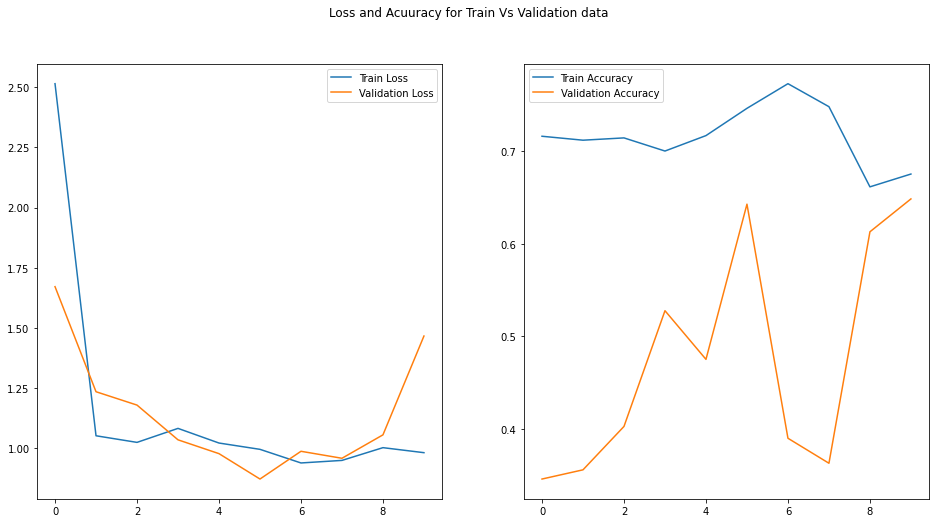

In [ ]:
# Plotting loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8),)
fig.suptitle('Loss and Acuuracy for Train Vs Validation data')
figsize=(16,16),
ax1.plot(h_4.history['loss'], label = 'Train Loss'),
ax1.plot(h_4.history['val_loss'], label = 'Validation Loss'),
ax1.legend()
ax2.plot(h_4.history['accuracy'], label = 'Train Accuracy'),
ax2.plot(h_4.history['val_accuracy'], label = 'Validation Accuracy')
ax2.legend();

Batch normalization made my model quite a bit worse. I will leave that out and try l2 regularization next.

In [ ]:
# Model with batch normalization 
model_5 = Sequential()

model_5.add(layers.Input(shape = (256,256,3)))

# The 1. below garuntees we get a float for the normalization
model_5.add(layers.Rescaling(1./255))


# First convolution
model_5.add(Conv2D(64, # Number of filters
                 (3,3), # Kernal size, generally 3 by 3
                 activation = 'relu'))

# Passing into the max pooling layer
model_5.add(MaxPooling2D(pool_size = (2,2), # Default pool size
                       ))
# Second Convolution
model_5.add(Conv2D(64, (3,3), activation='relu'))
model_5.add(MaxPooling2D(pool_size=(2,2)))

# Flatten
model_5.add(Flatten())



# Fully Connected
model_5.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_5.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))


#Compile
model_5.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# Fitting the model
h_5 = model_5.fit(train_ds, validation_data= val_ds, epochs = 10)

Epoch 1/10
89/89 [==============================] - 15s 156ms/step - loss: 0.6211 - accuracy: 0.8012 - val_loss: 0.5013 - val_accuracy: 0.8170
Epoch 2/10
89/89 [==============================] - 15s 165ms/step - loss: 0.5024 - accuracy: 0.8122 - val_loss: 0.4682 - val_accuracy: 0.8142
Epoch 3/10
89/89 [==============================] - 14s 151ms/step - loss: 0.4870 - accuracy: 0.8129 - val_loss: 0.5325 - val_accuracy: 0.7929
Epoch 4/10
89/89 [==============================] - 14s 149ms/step - loss: 0.4790 - accuracy: 0.8154 - val_loss: 0.4521 - val_accuracy: 0.8199
Epoch 5/10
89/89 [==============================] - 14s 150ms/step - loss: 0.4675 - accuracy: 0.8161 - val_loss: 0.4818 - val_accuracy: 0.8128
Epoch 6/10
89/89 [==============================] - 14s 149ms/step - loss: 0.4687 - accuracy: 0.8179 - val_loss: 0.4514 - val_accuracy: 0.8241
Epoch 7/10
89/89 [==============================] - 14s 151ms/step - loss: 0.4696 - accuracy: 0.8161 - val_loss: 0.4449 - val_accuracy: 0.8241

In [ ]:
# Scoring model
print(h_5.history['loss'][-1], h_5.history['val_loss'][-1])
print(h_5.history['accuracy'][-1], h_5.history['val_accuracy'][-1])

0.44810184836387634 0.4670831263065338
0.8338057994842529 0.8255318999290466


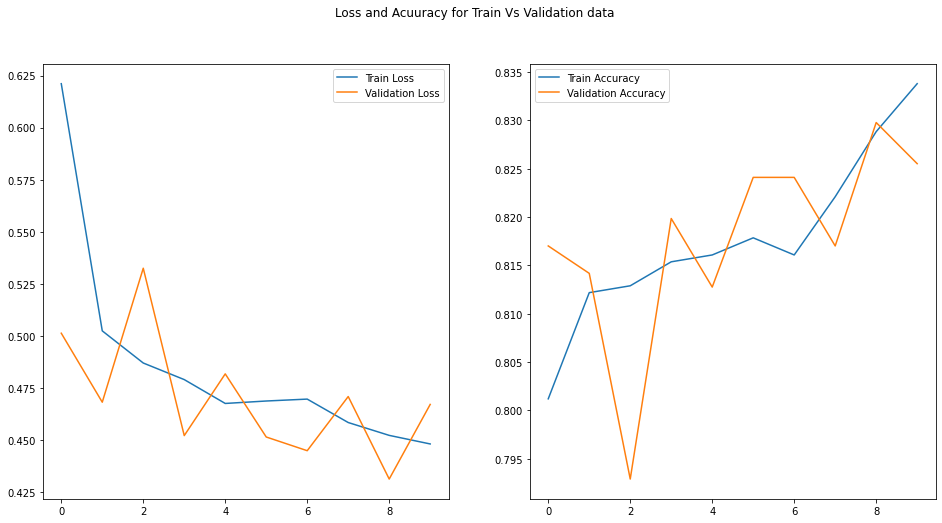

In [ ]:
# Plotting loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8),)
fig.suptitle('Loss and Acuuracy for Train Vs Validation data')
figsize=(16,16),
ax1.plot(h_5.history['loss'], label = 'Train Loss'),
ax1.plot(h_5.history['val_loss'], label = 'Validation Loss'),
ax1.legend()
ax2.plot(h_5.history['accuracy'], label = 'Train Accuracy'),
ax2.plot(h_5.history['val_accuracy'], label = 'Validation Accuracy')
ax2.legend();

In [ ]:
# Model with batch normalization 
model_5 = Sequential()

model_5.add(layers.Input(shape = (256,256,3)))

# The 1. below garuntees we get a float for the normalization
model_5.add(layers.Rescaling(1./255))


# First convolution
model_5.add(Conv2D(64, # Number of filters
                 (3,3), # Kernal size, generally 3 by 3
                 activation = 'relu'))

# Passing into the max pooling layer
model_5.add(MaxPooling2D(pool_size = (2,2), # Default pool size
                       ))
# Second Convolution
model_5.add(Conv2D(64, (3,3), activation='relu'))
model_5.add(MaxPooling2D(pool_size=(2,2)))

# Flatten
model_5.add(Flatten())



# Fully Connected
model_5.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model_5.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))


#Compile
model_5.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# Fitting the model
h_5 = model_5.fit(train_ds, validation_data= val_ds, epochs = 10)

Epoch 1/10
89/89 [==============================] - 441s 4s/step - loss: 0.5354 - accuracy: 0.7991 - val_loss: 0.4661 - val_accuracy: 0.8128
Epoch 2/10
89/89 [==============================] - 30s 318ms/step - loss: 0.4751 - accuracy: 0.8101 - val_loss: 0.4522 - val_accuracy: 0.8128
Epoch 3/10
89/89 [==============================] - 29s 311ms/step - loss: 0.4546 - accuracy: 0.8210 - val_loss: 0.4574 - val_accuracy: 0.8213
Epoch 4/10
89/89 [==============================] - 28s 311ms/step - loss: 0.4516 - accuracy: 0.8225 - val_loss: 0.4423 - val_accuracy: 0.8255
Epoch 5/10
89/89 [==============================] - 29s 314ms/step - loss: 0.4483 - accuracy: 0.8203 - val_loss: 0.4893 - val_accuracy: 0.8241
Epoch 6/10
89/89 [==============================] - 29s 317ms/step - loss: 0.4550 - accuracy: 0.8288 - val_loss: 0.4245 - val_accuracy: 0.8355
Epoch 7/10
89/89 [==============================] - 30s 332ms/step - loss: 0.4340 - accuracy: 0.8281 - val_loss: 0.4544 - val_accuracy: 0.8340
E

In [ ]:
# Scoring model
print(h_5.history['loss'][-1], h_5.history['val_loss'][-1])
print(h_5.history['accuracy'][-1], h_5.history['val_accuracy'][-1])

0.4339697062969208 0.41245412826538086
0.8341601490974426 0.8382978439331055


In [ ]:
# Previous base model with only 10 epochs score
print(h_1.history['loss'][-1], h_1.history['val_loss'][-1])
print(h_1.history['accuracy'][-1], h_1.history['val_accuracy'][-1])

0.4339589774608612 0.43006548285484314
0.8178596496582031 0.8269503712654114


In [ ]:
# Model with batch normalization 
model_6 = Sequential()

model_6.add(layers.Input(shape = (256,256,3)))

# The 1. below garuntees we get a float for the normalization
model_6.add(layers.Rescaling(1./255))


# First convolution
model_6.add(Conv2D(64, # Number of filters
                 (3,3), # Kernal size, generally 3 by 3
                 activation = 'relu'))

# Passing into the max pooling layer
model_6.add(MaxPooling2D(pool_size = (2,2), # Default pool size
                       ))
# Second Convolution
model_6.add(Conv2D(64, (3,3), activation='relu'))
model_6.add(MaxPooling2D(pool_size=(2,2)))

# Flatten
model_6.add(Flatten())



# Fully Connected
model_6.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model_6.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))


#Compile
model_6.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# Fitting the model
h_6 = model_6.fit(train_ds, validation_data= val_ds, epochs = 10)

Epoch 1/10
89/89 [==============================] - 46s 498ms/step - loss: 0.5167 - accuracy: 0.7998 - val_loss: 0.4725 - val_accuracy: 0.8199
Epoch 2/10
89/89 [==============================] - 47s 504ms/step - loss: 0.4691 - accuracy: 0.8147 - val_loss: 0.5784 - val_accuracy: 0.7943
Epoch 3/10
89/89 [==============================] - 45s 491ms/step - loss: 0.4715 - accuracy: 0.8168 - val_loss: 0.4412 - val_accuracy: 0.8227
Epoch 4/10
89/89 [==============================] - 44s 484ms/step - loss: 0.4535 - accuracy: 0.8196 - val_loss: 0.4277 - val_accuracy: 0.8213
Epoch 5/10
89/89 [==============================] - 46s 497ms/step - loss: 0.4450 - accuracy: 0.8313 - val_loss: 0.4139 - val_accuracy: 0.8270
Epoch 6/10
89/89 [==============================] - 45s 481ms/step - loss: 0.4479 - accuracy: 0.8274 - val_loss: 0.4865 - val_accuracy: 0.8170
Epoch 7/10
89/89 [==============================] - 44s 481ms/step - loss: 0.4459 - accuracy: 0.8271 - val_loss: 0.4088 - val_accuracy: 0.8284

In [ ]:
# Scoring model
print(h_6.history['loss'][-1], h_6.history['val_loss'][-1])
print(h_6.history['accuracy'][-1], h_6.history['val_accuracy'][-1])

0.39500007033348083 0.3654710352420807
0.8504606485366821 0.873758852481842


In [ ]:
# Previous base model with only 10 epochs score
print(h_1.history['loss'][-1], h_1.history['val_loss'][-1])
print(h_1.history['accuracy'][-1], h_1.history['val_accuracy'][-1])

0.2958850860595703 0.27562934160232544
0.8756201267242432 0.8879432678222656


Batch normalization also inhibited my model. The baseline model with 10 epochs is still the strongest.

In [ ]:
# Model with dropout
model_7 = Sequential()

model_7.add(layers.Input(shape = (256,256,3)))

# The 1. below garuntees we get a float for the normalization
model_7.add(layers.Rescaling(1./255))


# First convolution
model_7.add(Conv2D(64, # Number of filters
                 (3,3), # Kernal size, generally 3 by 3
                 activation = 'relu'))
model_7.add(Dropout(.05))
# Passing into the max pooling layer
model_7.add(MaxPooling2D(pool_size = (2,2), # Default pool size
                       ))
# Second Convolution
model_7.add(Conv2D(64, (3,3), activation='relu'))
model_7.add(Dropout(.04))
model_7.add(MaxPooling2D(pool_size=(2,2)))

# Flatten
model_7.add(Flatten())



# Fully Connected
model_7.add(Dropout(.05))
model_7.add(Dense(64, activation='relu', kernel_regularizer=l2(0.001)))
model_7.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))


#Compile
model_7.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# Fitting the model
h_7 = model_7.fit(train_ds, validation_data= val_ds, epochs = 10)

Epoch 1/10
89/89 [==============================] - 46s 489ms/step - loss: 0.5450 - accuracy: 0.7906 - val_loss: 0.5525 - val_accuracy: 0.7986
Epoch 2/10
89/89 [==============================] - 46s 501ms/step - loss: 0.4966 - accuracy: 0.8030 - val_loss: 0.4513 - val_accuracy: 0.8213
Epoch 3/10
89/89 [==============================] - 46s 504ms/step - loss: 0.4624 - accuracy: 0.8172 - val_loss: 0.4461 - val_accuracy: 0.8255
Epoch 4/10
89/89 [==============================] - 47s 509ms/step - loss: 0.4583 - accuracy: 0.8193 - val_loss: 0.4437 - val_accuracy: 0.8255
Epoch 5/10
89/89 [==============================] - 46s 500ms/step - loss: 0.4563 - accuracy: 0.8203 - val_loss: 0.4362 - val_accuracy: 0.8284
Epoch 6/10
89/89 [==============================] - 45s 499ms/step - loss: 0.4545 - accuracy: 0.8235 - val_loss: 0.4252 - val_accuracy: 0.8312
Epoch 7/10
89/89 [==============================] - 48s 530ms/step - loss: 0.4405 - accuracy: 0.8310 - val_loss: 0.4554 - val_accuracy: 0.8227

In [ ]:
# Scoring model
print(h_7.history['loss'][-1], h_7.history['val_loss'][-1])
print(h_7.history['accuracy'][-1], h_7.history['val_accuracy'][-1])

0.4517883360385895 0.425717830657959
0.8253012299537659 0.8269503712654114


In [ ]:
# Previous base model with only 10 epochs score
print(h_1.history['loss'][-1], h_1.history['val_loss'][-1])
print(h_1.history['accuracy'][-1], h_1.history['val_accuracy'][-1])

0.2958850860595703 0.27562934160232544
0.8756201267242432 0.8879432678222656


Dropout also made the model score more porrly. Moving on to calculating scores with teh base model fit on augmented images with 10 epochs.

# Testing model with image

In [61]:
# Turn ALL image into array to feed into model to predict
test_img_all = img_to_array(load_img('/content/drive/MyDrive/datasets/C-NMC_Leukemia/training_data/fold_1/all/UID_51_180_2_all.bmp'))
test_img_all.shape

(450, 450, 3)

In [62]:
# Need to reshape image
test_img_all = smart_resize(test_img_all, (256,256))
test_img_all.shape

(256, 256, 3)

In [63]:
# Adding extra dimension for model to work
test_image_all = np.expand_dims(test_img_all, axis = 0)
test_image_all.shape

(1, 256, 256, 3)

In [64]:
# Predicting if image is ALL
model_1.predict(test_image_all)

1/1 [==============================] - 0s 27ms/step


array([[0.0452757]], dtype=float32)

The model is over 95% sure this is a cancerous ALL cell

---



In [66]:
# Turn HEM image into array to feed into model to predict
test_img_hem = img_to_array(load_img('/content/drive/MyDrive/datasets/C-NMC_Leukemia/training_data/fold_1/hem/UID_H22_36_8_hem.bmp'))
test_img_hem.shape

(450, 450, 3)

In [67]:
# Need to reshape image
test_img_hem = smart_resize(test_img_hem, (256,256))
test_img_hem.shape

(256, 256, 3)

In [68]:
# Adding extra dimension for model to work
test_image_hem = np.expand_dims(test_img_hem, axis = 0)
test_image_hem.shape

(1, 256, 256, 3)

In [69]:
# Predicting if image is ALL
model_1.predict(test_image_hem)

1/1 [==============================] - 0s 53ms/step


array([[0.99884796]], dtype=float32)

The model is over 99% sure this is a normal HEM cell
